### UChicago MSFM Project Lab (2023 Spring) with MSUSA

# Time scaling of rating transition matrix (Demo from CPM desk 4/13/2023)

## Referenced papers

- *Kreinin, A., & Sidelnikova, M. (2001). Regularization algorithms for transition matrices. Algo Research Quarterly, 4(1/2), 23-40.*
- *Inamura, Y. (2006). Estimating continuous time transition matrices from discretely observed data. Bank of Japan, (06-E07).*

### Imports

In [1]:
import time as tm
import datetime as dtm
import random as rd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as lg

In [2]:
print('>>> the version of pandas package...')
print(pd.__version__)

>>> the version of pandas package...
0.23.4


### Constants

In [3]:
# constants
num_week = 52
dic_scn = {'sp_raw': 'S&P raw',
           'sp_adj': 'S&P adj',
           'mdy_raw': "Moody's raw",
           'mdy_adj': "Moody's adj",
           'test': 'Hypothetical Test',
           }
# constants for visualization
size_figm = (6,5)  #(6,4)
size_figl = (13,5) #(13,4)
size_fntl = 12.0
widh_lin = 0.2
cmap_trg1 = 'YlGnBu'
cmap_trg2 = 'pink'
cmap_trg3 = 'vlag'
cmap_trg4 = 'PuOr'
# 'Paired', 'Accent', 'CMRmap', 'CMRmap_r', 'brg_r', 'gnuplot', 'plasma', 'YlOrBr', 'Reds', 'PuRd', 'PuOr', autumn', 'Spectral'
cmaps_trg = (cmap_trg1,cmap_trg2)
# figure parameters
val_cmin = 0.00
val_cmax = 0.95
val_cneg = -5.0e-5
# titles
subtitle1 = 'Probability Heatmap'
subtitle2 = 'Negative Probability Grid'
subtitle3 = 'Real Part of the Matrix'
subtitle4 = 'Imaginary Part of the Matrix'

## 1. Preparation

### 1.2. Helper Functions

In [4]:
#%% ####################################################################
# Helper function
# ######################################################################
def heatmap_matrix(mtx,vmin,vmax,cmap=cmap_trg1,header=None):
    fig, ax = plt.subplots(figsize=size_figm)
    sns.heatmap(mtx,linewidth=widh_lin,cmap=cmap,vmin=vmin,vmax=vmax,ax=ax)
    if header is not None:
        fig.suptitle(header,fontsize=size_fntl,x=0.46,y=0.96)
    plt.show()

def multi_heatmap_matrix(mtx,vmins,vmaxs,cmaps,header=None,submtx=np.nan,sub1=subtitle1,sub2=subtitle2):
    try:
        submtx.empty
    except:
        submtx = mtx.copy()
    fig, ax = plt.subplots(1,2,figsize=size_figl)
    sns.heatmap(mtx,linewidth=widh_lin,cmap=cmaps[0],vmin=vmins[0],vmax=vmaxs[0],ax=ax[0])
    sns.heatmap(submtx,linewidth=widh_lin,cmap=cmaps[1],vmin=vmins[1],vmax=vmaxs[1],ax=ax[1])
    ax[0].set_title(sub1)
    ax[1].set_title(sub2)
    if header is not None:
        fig.suptitle(header,fontsize=size_fntl,x=0.50,y=01.00)
    plt.show()
    
def build_rtm_df(arr,lst_idx):
    return pd.DataFrame(arr,index=lst_idx,columns=lst_idx)

## 2. Scaling by power roots (example of RTM from rating agencies)

In our xVA pricings/trading, rating plays an important role, however, there is no common standard or theory how to consider the risk of rating changes. One of useful reference is to use rating transition data or rating transition matrix that some rating agencies publish.

The rating transition matrices are typically estimated from their historical sample data on annual basis, whilst we would like to use the information at more glanular scale (e.g. weekly). The historically estimated RTM does not guarantee any mathematically useful features, which implies that the matrix may not have power root with real numbers, or may contain negative probabilities even available in real numbers.

### 2.1. Import Data

In [5]:
#%% ####################################################################
# Setting
# ######################################################################
# keys for simulations
file_mtx = 'transitionmatrix.xlsx'
sht_trg = 'sp_adj'
trg_src = dic_scn[sht_trg]
# 'sp_raw', 'sp_adj', 'mdy_raw', 'mdy_adj', 'test'


In [6]:
#%% ####################################################################
# Data extraction
# ######################################################################
# data feed
df_raw = pd.read_excel(f'./transitionmatrix.xlsx',sheet_name=sht_trg,index_col=0,parse_dates=True)
lst_rating = list(df_raw.index)
# rating transition matrix
df_rtm = df_raw[lst_rating]


### 2.2. Original RTM (Annual)

Here is the RTM (Rating Transition Matrix) published by S&P Global (but adjusted to exclude transition to non-rated and scaled the matrix to make the total probability to be exact one). Diagonal components (probabilities to keep the current ratings) are close to be one.

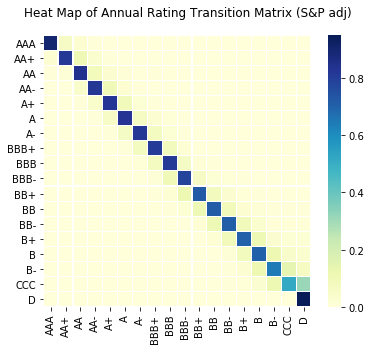

In [7]:
#%% ####################################################################
# Annual
# ######################################################################
# params aggregatese
vmins_trg = (val_cmin, val_cneg)
vmaxs_trg = (val_cmax, val_cmin)
# visualize
title = 'Heat Map of Annual Rating Transition Matrix ('+trg_src+')'
heatmap_matrix(df_rtm,vmin=val_cmin,vmax=val_cmax,header=title)


### 2.3. Weekly scaled RTM by 52nd power root

Here is the RTM scaled to weekly basis by taking 52nd power root of the RTM. A table right side shows grids where components are negative numbers.

This problems is so-called **embeddability problem**, and based on ***Inamura (2006)*** the problem may be happening when *there are stats i and j such that j is accessible from i, but $p_{ij}=0$*, where $i$ and $j$ denote ratings.

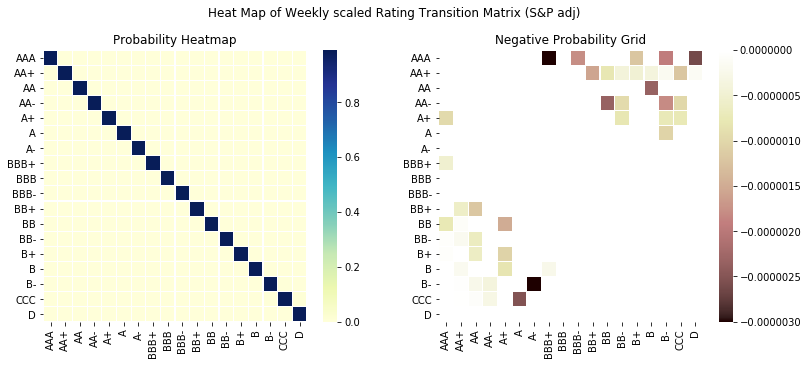

In [8]:
#%% ####################################################################
# Weekly
# ######################################################################
r52_rtm = build_rtm_df(lg.fractional_matrix_power(df_rtm,1.0/num_week),lst_rating)

# params aggregatese
vmins_trg = (val_cmin, -3.0e-6)
vmaxs_trg = (0.99, val_cmin)
# visualization
title = 'Heat Map of Weekly scaled Rating Transition Matrix ('+trg_src+')'
multi_heatmap_matrix(r52_rtm,vmins_trg,vmaxs_trg,cmaps_trg,header=title)


### 2.4. Weekly scaled RTM floored at zero vs replication

When taking positive part of the weekly scaled RTM (e.g. floored at zero) and revert back to annual scale by raising to 52nd power, the reverted annula matrix shows minor difference from the original matrix, whose error comes from negative numbers cut off at weekly scale. 

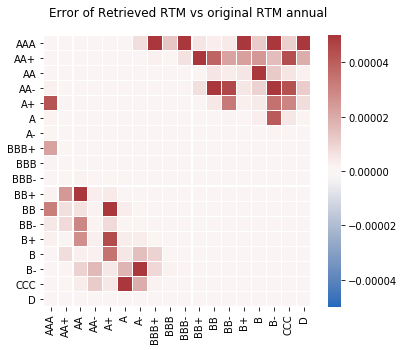

In [9]:
#%% ####################################################################
# Floored at zero
# ######################################################################
r52_rtm_floored = np.maximum(r52_rtm,0.0)
rtm_recovered = build_rtm_df(lg.fractional_matrix_power(r52_rtm_floored,num_week),lst_rating)
rtm_error = rtm_recovered-df_rtm

# figure parameters
err_cmax =  5.0e-5
err_cmin = -5.0e-5
# visualize
title = 'Error of Retrieved RTM vs original RTM annual'
heatmap_matrix(rtm_error,vmin=err_cmin,vmax=err_cmax,cmap=cmap_trg3,header=title)


### 2.5. Problem of this approach

The approach taken here should have many problems. For example,

1. The flooring was done at specific time scale (e.g. weekly in the case above), so there is no consistency between different time scale. For example, when taking the same flooring approach for **quarterly scale**, that should not agree with what was recovered to **quarterly scale from floored weekly RTM**.
1. We did not make any adjustment for RTM to offset the impact from flooring, so the floored RTM is actually **NOT RTM to meet the nature of the probability where sum of values of each row must be exactly one**.
1. To take floor at zero does not make any mathematical sense and that **drops information**. Also, if the magnitude of the value cut off by floor would be the larger, the more information will be lost then we will likely see the larger error when recovering the matrix to annual.


### 2.6. Possible approaches

In order to deal with the problems exemplified above,

1. We may deal with this problem by assuming **continuous** time model, rather discrete time model. **Generator** method would be an approach that is suitable to this purpose.
1. We should make some **adjustments** to make the RTMs with any time scale to be transition probability matrixes.
1. We should better to assume that the RTM provided from rating agencies is mathematically **dirty/incomplete**, whilst we assumed that the RTM was perfect information. We may use some **statistical inferences** or **Bayesian approaches** to deal with this point.

***Inamura (2006)*** well summarizes some possible approaches from previous researches. Let's try some of the approaches here.

## 3. Approach \#1 - Diagonal Adjustment (DA)

### 3.1. Calculating the generator in raw

A generator of the matrix can be obtained by taking a logarithm as follows.

<font color="blue">**Note: continuous, need to time $\Delta$t later**</font>

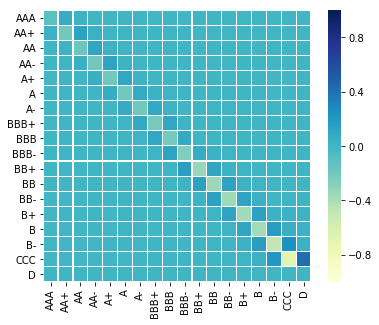

In [10]:
# data feed
gen_m = lg.logm(df_rtm)
df_gen_m = build_rtm_df(gen_m,lst_rating)
heatmap_matrix(df_gen_m,1.0,-1.0)

### 3.2. DA algorithm to the raw generator

DA algorithm roughly does the following two steps: The 1st issue seen in the previous section can be dealt by taking a generator, and the 2nd issue is corrected by the step 2 below. Still may have trouble for the 3rd issue.

1. flooring the generator at zero.
1. adjusting only the diagonal components to offset the impact from flooring and to make the new generator meet requirements to be an RTM generator.

In [11]:
trg_method = 'DA'
# DA Algorithm
# floored at zero (diagonals are floored here but overwritten later)
gen_da = np.maximum(gen_m,0.0)
for i in range(len(gen_da)):
    gen_da[i,i] = (-1.0)*(gen_da[i,:].sum() - gen_da[i,i])

### 3.3. Weekly scaled RTM with DA

With the DA algorithm, we now can obtain weekly scaled matrix without negative probabilities as follows.

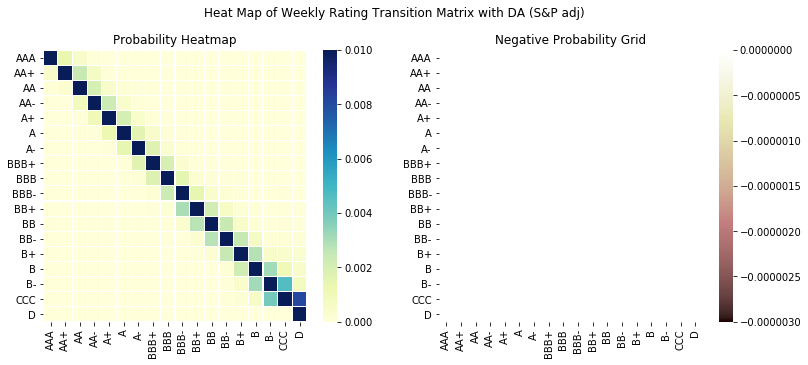

In [12]:
# Weekly scale
t = 1.0/num_week
rtm_weekly = lg.expm(gen_da*t)
df_rtm_weekly = build_rtm_df(rtm_weekly,lst_rating)
# params aggregatese
vmins_trg = (val_cmin, -3.0e-6)
vmaxs_trg = (0.01, val_cmin)
# visualization
title = 'Heat Map of Weekly Rating Transition Matrix with '+trg_method+' ('+trg_src+')'
multi_heatmap_matrix(df_rtm_weekly,vmins_trg,vmaxs_trg,cmaps_trg,header=title)

### 3.4. Error when reverting back to annual RTM with DA

We can see that the probabilities in top right area and bottom left area are added up for conpensation of lost diagonal probabilities.

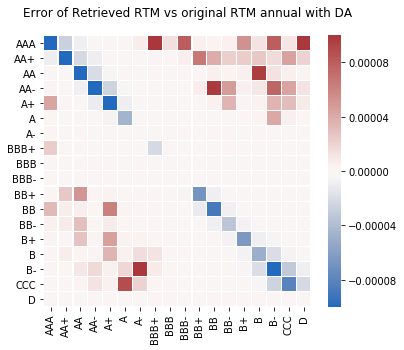

In [13]:
# validation
df_rtm_recovered = build_rtm_df(lg.expm(gen_da*1.0),lst_rating)
rtm_error = df_rtm_recovered-df_rtm
# figure parameters
err_cmax =  1.0e-4
err_cmin = -1.0e-4
# visualize
title = 'Error of Retrieved RTM vs original RTM annual with ' + trg_method
heatmap_matrix(rtm_error,vmin=err_cmin,vmax=err_cmax,cmap=cmap_trg3,header=title)

## 4. Approach \#2 - Weighted Adjustment (WA)

### 4.1. WA algorithm to the raw generator

WA algorithm roughly differs from DA algorithm at 2nd step below:

1. flooring the generator at zero.
1. adjusting each row of the generator by weighted scale to make the new generator meet requirements to be an RTM generator.

In [14]:
trg_method = 'WA'
# DA Algorithm
gen_wa = gen_m.copy()
# floored at zero
for i in range(len(gen_wa)):
    for j in range(len(gen_wa)):
        if i != j:
            gen_wa[i,j] = np.maximum(gen_wa[i,j],0.0)
# weighting
weight = gen_wa[:-1,:].sum(axis=1)/np.abs(gen_wa[:-1,:]).sum(axis=1)
for i in range(len(gen_wa)-1):
    gen_wa[i,:] = gen_wa[i,:] - np.abs(gen_wa[i,:])*weight[i]


### 4.2. Weekly scaled RTM with WA

With the WA algorithm, we now can obtain weekly scaled matrix without negative probabilities again.

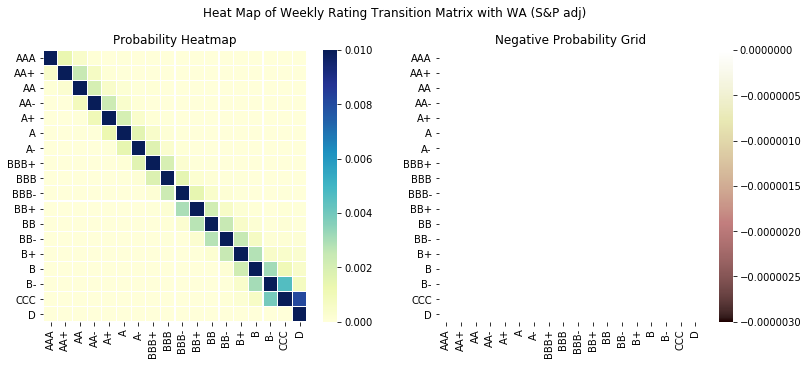

In [15]:
# Weekly scale
t = 1.0/num_week
rtm_weekly = lg.expm(gen_wa*t)
df_rtm_weekly = build_rtm_df(rtm_weekly,lst_rating)
# params aggregatese
vmins_trg = (val_cmin, -3.0e-6)
vmaxs_trg = (0.01, val_cmin)
# visualization
title = 'Heat Map of Weekly Rating Transition Matrix with '+trg_method+' ('+trg_src+')'
multi_heatmap_matrix(df_rtm_weekly,vmins_trg,vmaxs_trg,cmaps_trg,header=title)


### 4.3. Error when reverting back to annual RTM with WA

We can see that the probabilities in top right area and bottom left area are added up for conpensation of lost diagonal probabilities. Compared to DA algorithm, the conpensation happens not only at diagonal components, but also happening around there, that makes sense given the difference of the 2nd step of the algorithm.

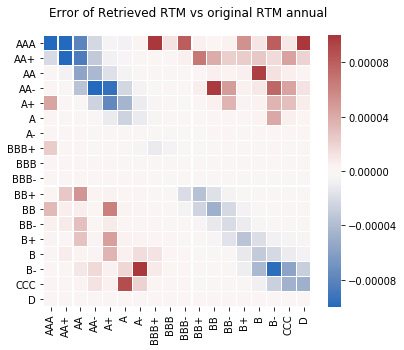

In [16]:
# validation
df_rtm_recovered = build_rtm_df(lg.expm(gen_wa*1.0),lst_rating)
rtm_error = df_rtm_recovered-df_rtm
# figure parameters
err_cmax =  1.0e-4
err_cmin = -1.0e-4
# visualize
title = 'Error of Retrieved RTM vs original RTM annual'
heatmap_matrix(rtm_error,vmin=err_cmin,vmax=err_cmax,cmap=cmap_trg3,header=title)


## 5. Further Approaches

***Inamura (2006)*** compares further three approaches:

- **Quasi-optimization**
- **EM algorithm**
- **MCMC (Marcov Chain Monte Carlo)** (\* make sure not implying Mizuho Capital Markets Corporation, the former entity of MSUSA fixed income division!)

Actually, DA and WA algorithms still do the similar adjusments of flooring at zero as we first made, which does not make any statistical sense (3rd issue). Also not sure how it works when encountering complex numbers. Hope to find a way to deal with it over these approaches above. We did not implement them yet, so it would be a possible next step for the team to start with, whilst it is up to you.

Also, we expect you for the project to:
1. Look for **further modern/sophisticated approaches** if possible in addition to them.
2. Analyze **pros/cons** over approaches by applying **various RTMs** you found.


### 5.1. QOG （Quasi-optimization Generator）

In [17]:
# gen_m = lg.logm(df_rtm)
trg_method = 'QOG'

In [18]:
def qog_algorithm(p_matrix):
    # Step 1: Construct b
    K = p_matrix.shape[0]
    a = lg.logm(p_matrix)
    lambd = -np.mean(a)
    b = a + lambd*np.ones((K,K))
    
    # Step 2: Permute b
    sorted_indices = np.argsort(b, axis=1)
    a_hat = np.array([b[i,sorted_indices[i]] for i in range(K)])
    
    # Step 3: Find m*
    q_matrix=np.zeros((K,K))
    for i in range(0,K):
        m_star = 2
        while m_star <= K-1 and ((K-m_star+1)*a_hat[i,m_star] - np.sum(a_hat[i,m_star:]) - a_hat[i,0]) < 0:
            m_star += 1
        # Step 4: Construct z*
        z_star = np.zeros(K)
        z_star[1:m_star] = 0
        z_star[m_star:] = a_hat[i,m_star:] - ((np.sum(a_hat[i,0]) + np.sum(a_hat[i,m_star:])) / (K-m_star+1))
        z_star[0] = a_hat[i,0] - ((np.sum(a_hat[i,0]) + np.sum(a_hat[i,1:])) / (K-m_star+1))    
        # Step 5: Inverse permutation to get the generator matrix Q
        q_matrix_row = np.zeros(K)
        for j in range(K):
            q_matrix_row[sorted_indices[i][j]] = z_star[j]
        q_matrix[i,:] = q_matrix_row   
    return q_matrix


In [19]:
gen_qog = qog_algorithm(df_rtm)

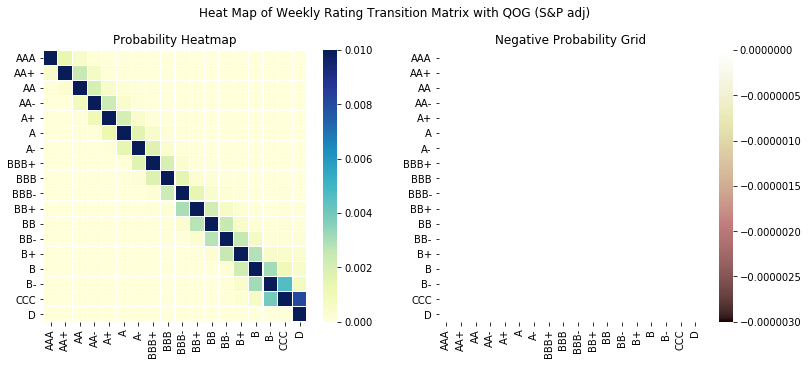

In [20]:
# Weekly scale
t = 1.0/num_week
rtm_weekly = lg.expm(gen_qog*t)
df_rtm_weekly = build_rtm_df(rtm_weekly,lst_rating)
# params aggregatese
vmins_trg = (val_cmin, -3.0e-6)
vmaxs_trg = (0.01, val_cmin)
# visualization
title = 'Heat Map of Weekly Rating Transition Matrix with '+trg_method+' ('+trg_src+')'
multi_heatmap_matrix(df_rtm_weekly,vmins_trg,vmaxs_trg,cmaps_trg,header=title)

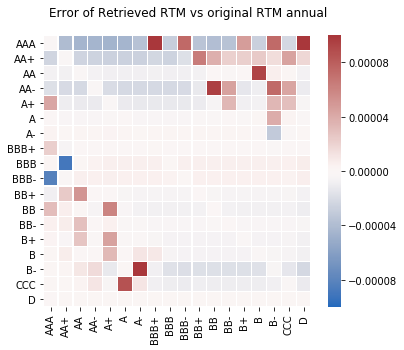

In [21]:
# validation
df_rtm_recovered = build_rtm_df(lg.expm(gen_qog*1.0),lst_rating)
rtm_error = df_rtm_recovered-df_rtm
# figure parameters
err_cmax =  1.0e-4
err_cmin = -1.0e-4
# visualize
title = 'Error of Retrieved RTM vs original RTM annual'
heatmap_matrix(rtm_error,vmin=err_cmin,vmax=err_cmax,cmap=cmap_trg3,header=title)


### 5.1. EM Algorithm

In [22]:
# EM Algorithm
trg_method = 'EM'


In [23]:
# Tak modified for review purpose
def em_algorithm(pm, guessm, niter=1000, epsil=1.0e-7, freq_status=None, is_log=True):
    n = pm.shape[1]
    q = guessm
    loglivec = []

    # series for log
    sr_log = pd.Series()
    
    # initialize
    iter = 0
    # loop
    for k in range(niter):
        # E Step1: Compute ERiT (i.e. the expectation of the holding time of state i in the interval [0, T])
        ERiT = np.zeros(n)
        for i in range(n):
            eieit = np.zeros((n, n))
            eieit[i, i] = 1
            augmentm = np.vstack((np.hstack((q, eieit)), np.hstack((np.zeros((n, n)), q))))
            integralm = lg.expm(augmentm)[0:n, n:2*n]
            ERiT[i] = np.nansum(pm * integralm/lg.expm(q))


        # E Step2: Compute ENijT (i.e. the expectation of the number of jumps from i to j in the interval [0, T])        
        ENijT = np.zeros((n, n))
        for i in range(n):
            for j in set(range(n)).difference([i]):
                eiejt = np.zeros((n, n))
                eiejt[i, j] = 1
                augmentm = np.vstack((np.hstack((q, eiejt)), np.hstack((np.zeros((n, n)), q))))
                integralm = q[i, j] * lg.expm(augmentm)[0:n, n:2*n]
                ENijT[i, j] = np.nansum(pm * integralm/lg.expm(q))

        # M Step: Compute generator estimate q-tilda that miximizing the expected log-liklihood function
        qtilda = ENijT/ERiT[:, None]
        np.fill_diagonal(qtilda, -np.sum(qtilda, axis=1))
        
        # Check convergence of the expected log-likelihood for early stopping
        logli = 0.0
        for i in range(n):
            for j in range(n):
                if q[i, j] > 0 and i != j:
                    logli = logli + (ENijT[i, j] * np.log(q[i, j]) - q[i, j] * ERiT[i])
        
        
        loglivec.append(logli)
        rel_error = abs(loglivec[-1] - loglivec[-2])/abs(loglivec[-2]) if k > 0 else np.nan
        if rel_error <= epsil:
            q = qtilda
            break

        q = qtilda

        # store convergence log
        sr_log.loc[k] = rel_error
        
        # monitor iterations
        if freq_status != None and iter != 0:
            if iter%freq_status == 0:
                print(f'Iteration: {iter} --- err: {rel_error}')
        # iterate
        iter = iter + 1

    # summary
    print(f"The algorithm converges in {iter} steps, with relative error {rel_error} vs threshold {epsil}" )

    # return
    return q, sr_log
            

### 5.2. Null Initial Guess

In [41]:
dim_rtm = len(df_rtm)

# initial guess
guessm = np.ones((dim_rtm, dim_rtm))
for i in range(dim_rtm):
    guessm[i][i] = (-1.0)*float(dim_rtm-1.0)
guessm[-1] = [0]*int(dim_rtm)

# starting from smaller members
guessm /= dim_rtm

In [42]:
num_iter = 10000
freq_check = 5
eps = 1.0e-16
# EM algorithm
gen_em, sr_err = em_algorithm(df_rtm,guessm,niter=num_iter,epsil=eps,freq_status=freq_check)


Iteration: 5 --- err: 0.001055310033121007
Iteration: 10 --- err: 1.757914747171769e-05
Iteration: 15 --- err: 1.499507909442996e-06
Iteration: 20 --- err: 9.24128638078425e-07
Iteration: 25 --- err: 4.180688412569325e-07
Iteration: 30 --- err: 2.1629596589351346e-07
Iteration: 35 --- err: 1.3221514059341085e-07
Iteration: 40 --- err: 9.132910124179549e-08
Iteration: 45 --- err: 6.80363009411168e-08
Iteration: 50 --- err: 5.305693532520672e-08
Iteration: 55 --- err: 4.260349061718472e-08
Iteration: 60 --- err: 3.490194966562278e-08
Iteration: 65 --- err: 2.9011442374645173e-08
Iteration: 70 --- err: 2.4382238397217748e-08
Iteration: 75 --- err: 2.0669328621585887e-08
Iteration: 80 --- err: 1.7644169691831838e-08
Iteration: 85 --- err: 1.514876937600973e-08
Iteration: 90 --- err: 1.306997543599544e-08
Iteration: 95 --- err: 1.1324324607826184e-08
Iteration: 100 --- err: 9.848680852501271e-09
Iteration: 105 --- err: 8.594282736838361e-09
Iteration: 110 --- err: 7.522808924661484e-09
Iter

Iteration: 895 --- err: 3.663429654377632e-15
Iteration: 900 --- err: 3.663429654377697e-15
Iteration: 905 --- err: 3.2324379303333155e-15
Iteration: 910 --- err: 3.016942068311138e-15
Iteration: 915 --- err: 2.801446206288954e-15
Iteration: 920 --- err: 2.585950344266759e-15
Iteration: 925 --- err: 1.7239668961778597e-15
Iteration: 930 --- err: 2.154958620222346e-15
Iteration: 935 --- err: 1.723966896177894e-15
Iteration: 940 --- err: 2.1549586202223867e-15
Iteration: 945 --- err: 1.5084710341556828e-15
Iteration: 950 --- err: 1.7239668961779352e-15
Iteration: 955 --- err: 1.2929751721334604e-15
Iteration: 960 --- err: 1.2929751721334684e-15
Iteration: 965 --- err: 8.61983448088984e-16
Iteration: 970 --- err: 1.5084710341557288e-15
Iteration: 975 --- err: 8.61983448088992e-16
Iteration: 980 --- err: 4.309917240444978e-16
Iteration: 985 --- err: 8.619834480889988e-16
Iteration: 990 --- err: 8.619834480890019e-16
Iteration: 995 --- err: 8.619834480890049e-16
Iteration: 1000 --- err: 4.3

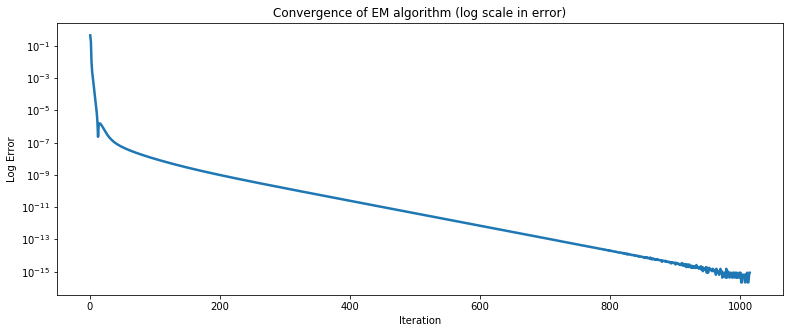

In [43]:
fig, ax = plt.subplots(1,1,figsize=size_figl)
sr_err.plot(ax=ax,lw=2.5)
ax.set_title('Convergence of EM algorithm (log scale in error)',fontsize=size_fntl)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log Error')
ax.set_yscale('log')
plt.show()

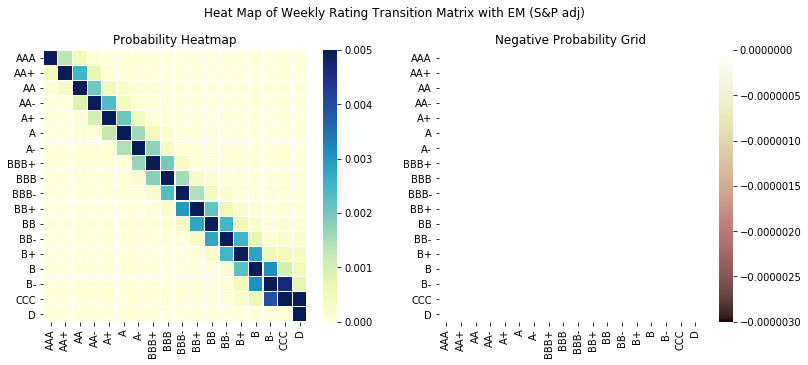

In [45]:
# Weekly scale
t = 1.0/num_week
rtm_weekly = lg.expm(gen_em*t)
df_rtm_weekly = build_rtm_df(rtm_weekly,lst_rating)
# params aggregatese
vmins_trg = (val_cmin, -3.0e-6)
vmaxs_trg = (0.005, val_cmin)
# visualization
title = 'Heat Map of Weekly Rating Transition Matrix with '+trg_method+' ('+trg_src+')'
multi_heatmap_matrix(df_rtm_weekly,vmins_trg,vmaxs_trg,cmaps_trg,header=title)

### 5.2. WA as Initial Guess

In [28]:
# another initial guess
num_iter = 1000
freq_check = 5
eps = 1.0e-16

# guess from WA estimate
guessm = gen_wa

# EM algorithm
gen_em2, sr_err2 = em_algorithm(df_rtm,guessm,niter=num_iter,epsil=eps,freq_status=freq_check)


Iteration: 5 --- err: 2.650747826387849e-07
Iteration: 10 --- err: 2.7674238775997753e-08
Iteration: 15 --- err: 1.68993689771026e-08
Iteration: 20 --- err: 9.698581219949555e-09
Iteration: 25 --- err: 5.294688725548709e-09
Iteration: 30 --- err: 2.8226059064621947e-09
Iteration: 35 --- err: 1.4792543087848045e-09
Iteration: 40 --- err: 7.585848683429339e-10
Iteration: 45 --- err: 3.744940966672356e-10
Iteration: 50 --- err: 1.7104833236443537e-10
Iteration: 55 --- err: 6.43134472184594e-11
Iteration: 60 --- err: 9.2779588703016e-12
Iteration: 65 --- err: 1.8180523947578354e-11
Iteration: 70 --- err: 3.099433892820228e-11
Iteration: 75 --- err: 3.6094694998535765e-11
Iteration: 80 --- err: 3.719480137016571e-11
Iteration: 85 --- err: 3.62817453938851e-11
Iteration: 90 --- err: 3.440930183850413e-11
Iteration: 95 --- err: 3.214099238484998e-11
Iteration: 100 --- err: 2.9761271571447696e-11
Iteration: 105 --- err: 2.7422279477098388e-11
Iteration: 110 --- err: 2.519534523212397e-11
Itera

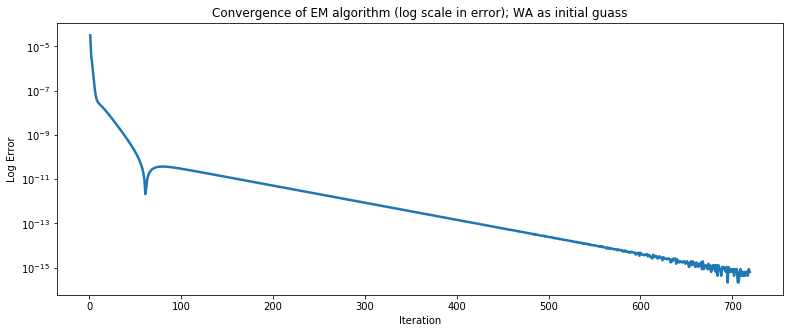

In [46]:
fig, ax = plt.subplots(1,1,figsize=size_figl)
sr_err2.plot(ax=ax,lw=2.5)
ax.set_title('Convergence of EM algorithm (log scale in error); WA as initial guass',fontsize=size_fntl)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log Error')
ax.set_yscale('log')
plt.show()

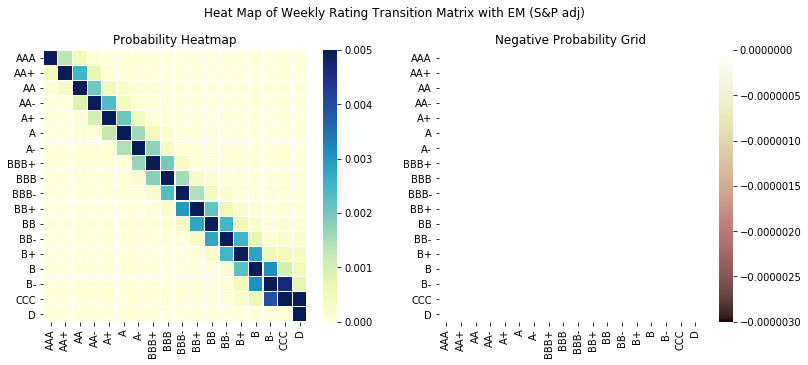

In [47]:
# Weekly scale
t = 1.0/num_week
rtm_weekly = lg.expm(gen_em2*t)
df_rtm_weekly = build_rtm_df(rtm_weekly,lst_rating)
# params aggregatese
vmins_trg = (val_cmin, -3.0e-6)
vmaxs_trg = (0.005, val_cmin)
# visualization
title = 'Heat Map of Weekly Rating Transition Matrix with '+trg_method+' ('+trg_src+')'
multi_heatmap_matrix(df_rtm_weekly,vmins_trg,vmaxs_trg,cmaps_trg,header=title)

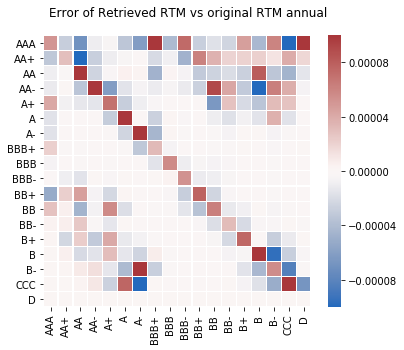

In [48]:
# validation
df_rtm_recovered = build_rtm_df(lg.expm(gen_em2*1.0),lst_rating)
rtm_error = df_rtm_recovered-df_rtm
# figure parameters
err_cmax =  1.0e-4
err_cmin = -1.0e-4
# visualize
title = 'Error of Retrieved RTM vs original RTM annual'
heatmap_matrix(rtm_error,vmin=err_cmin,vmax=err_cmax,cmap=cmap_trg3,header=title)